In [2]:
# To develop the Convolutional Neural Network (CNN) algorithm

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
from PIL import Image
from google.colab import files
from google.colab import drive
import os
import datetime
import urllib.request
import re
import numpy as np
import matplotlib.pyplot as plt
OMNI_ROOT = os.environ.get("OMNI_ROOT", "./omni")
omni_lowres_cache = {}

In [36]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Step 2: Define the full file path to your CSV in Google Drive
# Note: The path usually starts with '/content/drive/MyDrive/' (no space in MyDrive)
csv_path = '/content/drive/MyDrive/CNN_SDO/omni_timeseries1_final.csv'

# Step 3: Read the CSV file using pandas
omni = pd.read_csv(csv_path)

# Optional: Display the first few rows to verify
print(omni.head())

Mounted at /content/drive
              datetime   f107  kp  dst  sunspot
0   2024-01-01 6:00:00  131.2   7    3       55
1  2024-01-01 12:00:00  131.2  20   -3       55
2  2024-01-01 18:00:00  131.2  33  -27       55
3   2024-01-02 6:00:00  137.4   7  -14       68
4  2024-01-02 12:00:00  137.4  23   -6       68


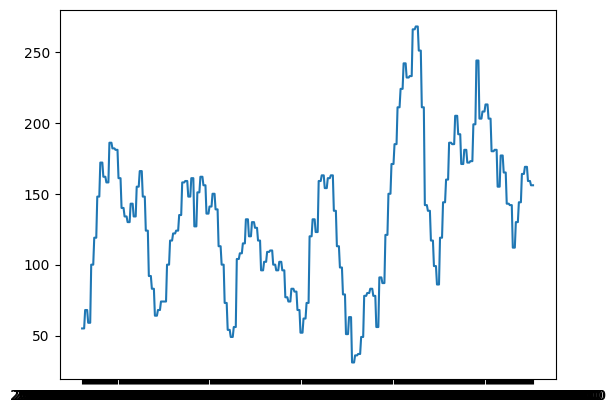

In [37]:
import matplotlib.pyplot as plt

plt.plot(omni.datetime,omni.sunspot)

(2664, 512, 512)


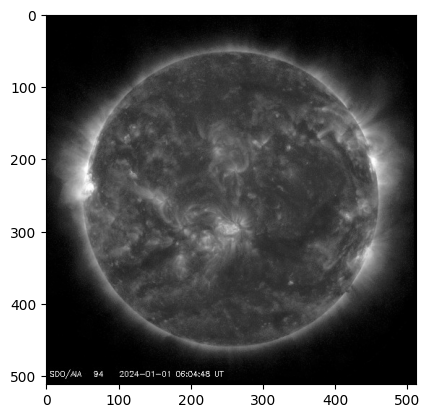

In [44]:
import os
from PIL import Image
import numpy as np

# Set your base directory
base_dir = '/content/drive/MyDrive/CNN_SDO/SDO_data'
wavelengths = ['0094', '0131', '0171', '0193', '0211', '0304']  # Update as needed

def load_and_preprocess_image(img_path, target_size=(512, 512), to_grayscale=False):
    """Load an image, resize, convert to array, and normalize."""
    img = Image.open(img_path)
    if to_grayscale:
        img = img.convert('L')  # Convert to grayscale
    else:
        img = img.convert('RGB')  # Ensure 3 channels

    img = img.resize(target_size)
    arr = np.array(img).astype('float32') / 255.0  # Normalize to [0, 1]
    return arr

# Example: Load all images for one wavelength
images = []
image_time = []
f107 = []
dst = []
kp = []
sunspot = []
for wl in wavelengths:
    folder = os.path.join(base_dir, wl)
    i_time = 0
    for fname in sorted(os.listdir(folder)):
        if fname.endswith('.jpg'):
            dt = datetime.datetime.strptime(fname[0:15], '%Y%m%d_%H%M%S')
            dt_omni = datetime.datetime.strptime(omni["datetime"][i_time], '%Y-%m-%d %H:%M:%S')
            img_path = os.path.join(folder, fname)
            arr = load_and_preprocess_image(img_path, target_size=(512, 512), to_grayscale=True)
            images.append(arr)
            image_time.append(dt)
            # if statement: to check for time:
            #print(omni["f107"][omni["datetime"] == dt])
            #f10_7.append(omni["f107"])
            if (dt_omni == dt):
                f107.append(omni["f107"][i_time])
                dst.append(omni["dst"][i_time])
                kp.append(omni["kp"][i_time])
                sunspot.append(omni["sunspot"][i_time])
            else:
                print("The world has fallen: " , dt, dt_omni)
                exit(1)
            i_time += 1

# Convert list to numpy array for ML (N, H, W, C)
images_np = np.stack(images)
print(images_np.shape)  # Should be (num_images, 512, 512, 3) for RGB

plt.imshow(images_np[0],cmap="gray")

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_np, np.array(f107), test_size=0.2, random_state=42)

In [52]:
y_train.shape

(2131,)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(512, 512, 1)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # 4 outputs: f10.7, Kp, Dst, sunspot_number
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train[..., np.newaxis], y_train, epochs=10, batch_size=16, validation_split=0.2)


In [ ]:
y_pred = model.predict(X_test[..., np.newaxis])
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print('Test MSE:', mse)